# Imports 

In [29]:
import pkg_resources  
import os.path

import os
import sys
import numpy as np
import pandas as pd
from argparse import ArgumentParser
from qfit.structure import Structure
import glob
from multiprocessing import Pool
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

import sklearn
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.transform import Rotation as R
from matplotlib import cm
from scipy.signal import argrelextrema

from sklearn.cluster import MeanShift
from sklearn.cluster import  estimate_bandwidth
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sklearn
from sklearn.model_selection  import LeaveOneOut
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from DICT4A import DICT4A

# functions

In [10]:
def new_dihedral(p):
    """
    Function for calculated the dihedral of a given set of 4 points.
    (not my function)
    Parameters 
    ----------
    p : nd.array, shape=(4, 3)
        4 points you want to calculate a dihedral from
    Returns
    -------
    dih_ang : float
        calculated dihedral angle
    """
    p0 = p[0]
    p1 = p[1]
    p2 = p[2]
    p3 = p[3]

    b0 = -1.0*(p1 - p0)
    b1 = p2 - p1
    b2 = p3 - p2
    b1 /= np.linalg.norm(b1)

    v = b0 - np.dot(b0, b1)*b1
    w = b2 - np.dot(b2, b1)*b1
    x = np.dot(v, w)
    y = np.dot(np.cross(b1, v), w)
    dih_ang = np.degrees(np.arctan2(y, x))
    return dih_ang

In [9]:
def rigid_transform_3D(A, B):
    '''
    * Not my function *
    from : https://github.com/nghiaho12/rigid_transform_3D/blob/master/rigid_transform_3D.py
    function for calculating the optimal rotation and transformation matrix for a set of 4 points
    onto another set of 4 points
    Input: expects 3xN matrix of points
    Returns R,t
        R = 3x3 rotation matrix
        t = 3x1 column vector
    '''
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B
    
    return R, t

In [138]:
def get_new_coords(all_coord_info,
                   res, 
                   center_coords, 
                   min_ang, 
                   spread, 
                   all_density_vals, 
                   cont_dict,
                   cutoff_idx,
                   all_xyz_coords,
                   rel_b_list,
                   q_list,
                   use_cutoff=True):
    # initialize output arrays
    new_center_coords = np.array([])
    new_all_xyz_coords = np.array([])
    dens_v_all = np.array([])
    new_all_density_vals = np.array([])
    b_all = np.array([])
    q_all = np.array([])
    new_spread = np.array([])
    for atom_set_spec, atom_set_gen in DICT4A[res.resn[0]].items(): # go through each set of 4 atoms in this residue
        n_idx=[]
        contin = True
        for at_s in atom_set_spec:
            if at_s in list(res.name):
                n_idx.append(list(res.name).index(at_s))
            else:
                contin = False
        if contin == True:
            coords = res.coor[n_idx]
            dih_val = new_dihedral(np.array(coords))
            bucket=[]
            # if dih cluster is just one peak
            if len(np.array(min_ang[tuple(atom_set_gen)])) == 0:
                dih_id = 0
            else:
                diff_from_mins = dih_val - np.array(min_ang[tuple(atom_set_gen)])
                closest_min_idx = np.argsort(abs(diff_from_mins))[0]
                if diff_from_mins[closest_min_idx]>0:
                    bucket.append(closest_min_idx+1)
                else:
                    bucket.append(closest_min_idx)
                if cont_dict[tuple(atom_set_gen)]:
                    bucket = np.array(bucket) + (np.array(bucket)==0)*(len(min_ang[tuple(atom_set_gen)]))
                dih_id = bucket[0]
            if use_cutoff:
                idx = cutoff_idx[tuple(atom_set_gen)][dih_id]
                all_wat_xyz_coords = np.array(all_xyz_coords[tuple(atom_set_gen)][dih_id])[idx]
                dens_vals = np.array(all_density_vals[tuple(atom_set_gen)][dih_id])[idx]
                bvals = np.array(rel_b_list[tuple(atom_set_gen)][dih_id])[idx]
                qvals = np.array(q_list[tuple(atom_set_gen)][dih_id])[idx]
            else:
                all_wat_xyz_coords = np.array(all_xyz_coords[tuple(atom_set_gen)][dih_id])
                dens_vals = np.array(all_density_vals[tuple(atom_set_gen)][dih_id])
                bvals = np.array(rel_b_list[tuple(atom_set_gen)][dih_id])
                qvals = np.array(q_list[tuple(atom_set_gen)][dih_id])
            p1 = all_coord_info[tuple(atom_set_gen)][dih_id][0]
            wat_centers = center_coords[tuple(atom_set_gen)][dih_id]
            sp = spread[tuple(atom_set_gen)][dih_id]


            R, t = rigid_transform_3D(np.array(p1).T, np.array(coords).T)

            new_center_coords_tmp=[]
            new_all_xyz_coords_tmp=[]
            new_spread_tmp=[]
            for wi, si in zip(wat_centers, sp):
                new_spread_tmp.append(si)
                new_center_coords_tmp.append((np.dot(R, np.array(wi).T)+t.T)[0]) # use same R and t on waters
            for wi in all_wat_xyz_coords:
                new_all_xyz_coords_tmp.append((np.dot(R, np.array(wi).T)+t.T)[0]) # use same R and t on waters

            new_center_coords = np.append(new_center_coords, new_center_coords_tmp)
            new_all_xyz_coords = np.append(new_all_xyz_coords, new_all_xyz_coords_tmp)
            dens_v_all = np.append(dens_v_all, dens_vals)
            b_all = np.append(b_all, bvals)
            q_all = np.append(q_all, qvals)
            new_spread = np.append(new_spread, new_spread_tmp)
    return new_center_coords, new_all_xyz_coords, dens_v_all, b_all, q_all, new_spread

In [249]:
def build_density_pdb(xyz_coor, fn, density):
    listy_wat = {}
    count=1
    sample = len(density)//10000 + 1
    for i, (xi, yi, zi, di) in enumerate(zip(np.array(xyz_coor)[:,0][::sample],
                                             np.array(xyz_coor)[:,1][::sample],
                                             np.array(xyz_coor)[:,2][::sample], 
                                        np.array(density)[::sample])):
        count=count+1
        listy_wat[i] = ['HETATM', str(count), 'O', 'HOH', str(count), str(format(xi, '.3f')), str(format(yi, '.3f')), str(format(zi, '.3f')), '1.00', str(format(di, '.3f')), 'O']

    file = fn
    file = open(file, "w") 
    for row in list(listy_wat.values()):
        file.write("{: >1} {: >4} {: >2} {: >5} {: >5} {: >11} {: >7} {: >7} {: >5} {: >5} {: >11}\n".format(*row))
    file.close()
    return

In [164]:
def build_center_placement_pdb(xyz_coor, pdb_fn, sphere_size_fn, spread):
    listy_wat = {}
    count=1
    sample = len(xyz_coor)//10000 + 1
    for i, (xi, yi, zi) in enumerate(zip(np.array(xyz_coor)[:,0][::sample],
                                         np.array(xyz_coor)[:,1][::sample],
                                         np.array(xyz_coor)[:,2][::sample])):
        listy_wat[i] = ['HETATM', str(i+1), 'O', 'HOH', str(i+1), str(format(xi, '.3f')), str(format(yi, '.3f')), str(format(zi, '.3f')), '1.00', '1.00', 'O']
    file = pdb_fn
    file = open(file, "w") 
    for row in list(listy_wat.values()):
        file.write("{: >1} {: >4} {: >2} {: >5} {: >5} {: >11} {: >7} {: >7} {: >5} {: >5} {: >11}\n".format(*row))
    file.close()
    with open(sphere_size_fn, 'w') as f:
        for i, (pt, rad) in enumerate(zip(xyz_coor, spread)): 
             f.write('set sphere_scale, %s, resi %s and idk4\n' % (rad/2, i))
    return

# load in data

In [3]:
os.chdir('/Users/catherinekuhn/Desktop/rotations/fraser/scripts/out')

In [180]:
pt=50
length = 50000
center_coords = np.load(f'center_coor_{length}_{pt}.npy',allow_pickle='TRUE').item()
cont_dict = np.load('cont_dict.npy',allow_pickle='TRUE').item()
cutoff_idx = np.load(f'cutoff_idx_{length}_{pt}.npy',allow_pickle='TRUE').item()
cutoff_idx_all = np.load(f'cutoff_idx_{length}_all.npy',allow_pickle='TRUE').item()
all_density_vals = np.load(f'density_vals_{length}_{pt}.npy',`ballow_pickle='TRUE').item()
labels = np.load(f'labels_{length}_{pt}.npy',allow_pickle='TRUE').item()
spread = np.load(f'spread_{length}_{pt}.npy',allow_pickle='TRUE').item()
min_ang = np.load('min_ang.npy',allow_pickle='TRUE').item()
all_coord_info = np.load('dih_info.npy',allow_pickle='TRUE').item()
all_xyz_coords = np.load(f'all_xyz_coords_{length}_{pt}.npy',allow_pickle='TRUE').item()
rel_b_list = np.load(f'rel_b_list_{length}_{pt}.npy',allow_pickle='TRUE').item()
q_list = np.load(f'q_list_{length}_{pt}.npy',allow_pickle='TRUE').item()

In [222]:
all_dens_vals=np.array([])
for atom_set, atom_set_val in all_density_vals.items():
    for dih, dens_val in atom_set_val.items():
        all_dens_vals = np.append(all_dens_vals, dens_val)
        
all_b_vals=np.array([])
for atom_set, atom_set_val in rel_b_list.items():
    for dih, b_val in atom_set_val.items():
        all_b_vals = np.append(all_b_vals, b_val)

all_q_vals=np.array([])
for atom_set, atom_set_val in q_list.items():
    for dih, q_val in atom_set_val.items():
        all_q_vals = np.append(all_q_vals, q_val)

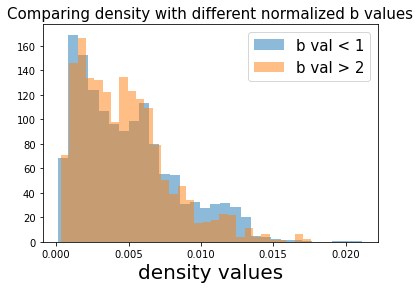

In [221]:
# this is only on a very small subset of the data
plt.hist(np.exp(all_dens_vals)[all_b_vals<1], density=True, alpha=.5, bins=30)
plt.hist(np.exp(all_dens_vals)[all_b_vals>3], density=True, alpha=.5, bins=30)
plt.legend(['b val < 1', 'b val > 2'], fontsize=15)
plt.title('Comparing density with different normalized b values', fontsize=15)
plt.xlabel('density values', fontsize=20)
plt.show()

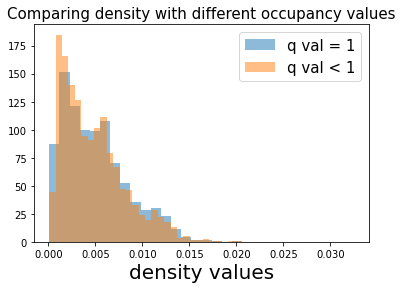

In [226]:
plt.hist(np.exp(all_dens_vals)[all_q_vals==1], density=True, alpha=.5, bins=30)
plt.hist(np.exp(all_dens_vals)[all_q_vals<1], density=True, alpha=.5, bins=30)
plt.legend(['q val = 1', 'q val < 1'], fontsize=15)
plt.title('Comparing density with different occupancy values', fontsize=15)
plt.xlabel('density values', fontsize=20)
plt.show()

In [25]:
s = Structure.fromfile('/Users/catherinekuhn/Downloads/3us6.pdb').reorder()

In [26]:
res = list(s.residues)[0]

In [181]:
new_coords, new_all_xyz_coords, dens_v_all, b_all, q_all, new_spread = get_new_coords(all_coord_info,
                                                                                       res, 
                                                                                       center_coords, 
                                                                                       min_ang, 
                                                                                       spread, 
                                                                                       all_density_vals, 
                                                                                       cont_dict,
                                                                                       cutoff_idx,
                                                                                       all_xyz_coords,
                                                                                       rel_b_list,
                                                                                       q_list,
                                                                                       use_cutoff=False
                                                                                     )